In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pymatgen.ext.matproj import MPRester
import numpy as np


In [2]:
import classiq
classiq.authenticate()

C:\Users\Ishara\AppData\Roaming\Python\Python312\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [3]:
n = 4
load_dotenv()
api_key = os.getenv("MPRESTER_API_KEY")

def get_material(id="mp-66"):
    with MPRester(api_key) as m:
        results = m.summary.search(material_ids=[id], fields=["material_id", "bulk_modulus", "shear_modulus"])
        for item in results:
            print(f"Material ID: {item.material_id}")
            print(f"Bulk Modulus (GPa): {item.bulk_modulus}")
            print(f"Shear Modulus (GPa): {item.shear_modulus}")
    return (item.bulk_modulus['vrh'], item.shear_modulus['vrh'])



In [4]:
# Step 1: Generate a mesh grid and its stiffness matrix

def generate_grid_stiffness(n, bulk_modulus, shear_modulus, h=0.34e-9, delta=1.0):
    """
    Generate a stiffness matrix for a 2D grid using real material properties.
    Inputs:
    - n: grid size (n x n)
    - bulk_modulus: K (Pa)
    - shear_modulus: G (Pa)
    - h: thickness of the material (m)
    - delta: grid spacing (m)
    """
    size = n * n
    A = np.zeros((size, size))
    f = np.zeros((size,))

    # Compute effective Young's modulus
    E = (9 * bulk_modulus * shear_modulus) / (3 * bulk_modulus + shear_modulus)

    # Scale stiffness value per node interaction
    stiffness = E / h * (1 / delta**2)

    for i in range(size):
        A[i][i] = 4 * stiffness  # main diagonal (4 neighbors)
        if i - 1 >= 0 and (i % n != 0):  # left neighbor
            A[i][i - 1] = -stiffness
        if i + 1 < size and ((i + 1) % n != 0):  # right neighbor
            A[i][i + 1] = -stiffness
        if i - n >= 0:  # top neighbor
            A[i][i - n] = -stiffness
        if i + n < size:  # bottom neighbor
            A[i][i + n] = -stiffness

    # Apply external force at the center
    center = size // 2
    f[center] = -10.0  # Newtons, for example

    return A, f


In [5]:
def plot_displacement(u, n):
    X, Y = np.meshgrid(range(n), range(n))
    U = u.reshape((n, n))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, U, cmap='viridis')
    ax.set_title("Displacement Profile")
    plt.show()


In [6]:
bulk_modulus, shear_modulus = get_material()
A, f = generate_grid_stiffness(n, bulk_modulus, shear_modulus)

C:\Users\Ishara\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Ishara\AppData\Local\Temp\ipykernel_7164\1430463414.py:7: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  results = m.summary.search(material_ids=[id], fields=["material_id", "bulk_modulus", "shear_modulus"])
Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<?, ?it/s]

Material ID: mp-66
Bulk Modulus (GPa): {'voigt': 435.156, 'reuss': 435.156, 'vrh': 435.156}
Shear Modulus (GPa): {'voigt': 522.224, 'reuss': 517.677, 'vrh': 519.951}


In [7]:
def transform_matrix_to_unit_interval(A, m=10):
    """
    Transform a Hermitian matrix A such that its eigenvalues are in the range (0, 1).
    
    Parameters:
        A (ndarray): Hermitian matrix.
        m (int): Determines how close eigenvalues will get to 1. Default is 10.
    
    Returns:
        A_tilde (ndarray): Transformed matrix with eigenvalues in (0, 1).
        transform_info (dict): Dictionary containing original min/max eigenvalues and scaling factors.
    """
    # Ensure matrix is Hermitian
    if not np.allclose(A, A.conj().T):
        raise ValueError("Matrix A must be Hermitian.")
    
    # Compute eigenvalues
    eigvals = np.linalg.eigvalsh(A)
    w_min = np.min(eigvals)
    w_max = np.max(eigvals)

    if w_min == w_max:
        raise ValueError("Matrix has constant eigenvalues; can't scale uniquely.")

    # Construct transformation constants
    shift = w_min
    scale_factor = (1 - 1 / (2 ** m)) / (w_min + w_max)

    # Apply transformation
    A_tilde = (A + shift * np.eye(A.shape[0])) * scale_factor

    return A_tilde, {
        "w_min": w_min,
        "w_max": w_max,
        "shift": shift,
        "scale_factor": scale_factor
    }





In [8]:
import numpy as np

# Normalize vector b
b = f / np.linalg.norm(f)
A, info = transform_matrix_to_unit_interval(A)
print("Original eigenvalue range: [{:.4f}, {:.4f}]".format(info["w_min"], info["w_max"]))
print("Transformed matrix eigenvalues:", np.linalg.eigvalsh(A))

print("A =", A, "\n")
print("b =", b)

# Verify if the matrix is symmetric and has eigenvalues in (0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

# Binary representation of eigenvalues (classically calculated)
m = 32  # Precision of a binary representation, e.g. 32 binary digits
sign = lambda num: "-" if num < 0 else ""  # Calculate sign of a number
binary = lambda fraction: str(
    np.binary_repr(int(np.abs(fraction) * 2 ** (m))).zfill(m)
).rstrip(
    "0"
)  # Binary representation of a fraction

print()
print("Eigenvalues:")
for eig in sorted(w):
    print(f"{sign(eig)}0.{binary(eig.real)} =~ {eig.real}")

Original eigenvalue range: [2506473600665.2134, 23741658713118.1484]
Transformed matrix eigenvalues: [0.1907965  0.31567443 0.31567443 0.44055236 0.47003204 0.47003204
 0.59490997 0.59490997 0.59490997 0.59490997 0.7197879  0.7197879
 0.74926758 0.87414551 0.87414551 0.99902344]
A = [[ 0.59490997 -0.12487793  0.          0.         -0.12487793  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.12487793  0.59490997 -0.12487793  0.          0.         -0.12487793
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.12487793  0.59490997 -0.12487793  0.          0.
  -0.12487793  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.12487793  0.59490997  0.          0.
   0.         -0.12487793  0.          0.          0.          0.
   0.          0.          

In [9]:
from classiq import *

hamiltonian = matrix_to_hamiltonian(A)
n = len(hamiltonian[0].pauli)
print("Pauli strings list: \n")
for pterm in hamiltonian:
    print(pterm.pauli, ": ", np.round(pterm.coefficient, 3))

print("\nNumber of qubits for matrix representation =", n)

Pauli strings list: 

[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>] :  0.595
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.I: 0>, <Pauli.X: 1>] :  -0.125
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.X: 1>, <Pauli.X: 1>] :  -0.062
[<Pauli.I: 0>, <Pauli.I: 0>, <Pauli.Y: 2>, <Pauli.Y: 2>] :  -0.062
[<Pauli.I: 0>, <Pauli.X: 1>, <Pauli.I: 0>, <Pauli.I: 0>] :  -0.125
[<Pauli.X: 1>, <Pauli.X: 1>, <Pauli.I: 0>, <Pauli.I: 0>] :  -0.062
[<Pauli.Y: 2>, <Pauli.Y: 2>, <Pauli.I: 0>, <Pauli.I: 0>] :  -0.062

Number of qubits for matrix representation = 4


In [10]:
@qfunc
def load_b(
    amplitudes: CArray[CReal], state: Output[QArray[QBit]], bound: CReal
) -> None:
    prepare_amplitudes(amplitudes, bound, state)

In [11]:
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
precision = 4


@qfunc
def simple_eig_inv(phase: QNum, indicator: Output[QBit]):
    allocate(1, indicator)
    C = 1 / 2**phase.size
    indicator *= C / phase


@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    bound: CReal,
    precision: CInt,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray[QBit]],
    state: Output[QArray[QBit]],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate a quantum number for the phase with given precision
    allocate_num(precision, False, precision, phase)

    # Prepare initial state
    load_b(amplitudes=amplitudes, state=state, bound=bound)

    # Perform quantum phase estimation and eigenvalue inversion within a quantum operation
    within_apply(
        lambda: qpe_flexible(
            unitary_with_power=lambda k: hamiltonian_evolution_with_power(k, state),
            phase=phase,
        ),
        lambda: simple_eig_inv(phase=phase, indicator=indicator),
    )

In [12]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)


# Construct a representation of HHL model
def hhl_model(main, backend_preferences):
    qmod_hhl = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )
    return qmod_hhl

In [13]:
def read_positions(circuit_hhl, res_hhl):
    # positions of control qubit
    target_pos = res_hhl.physical_qubits_map["indicator"][0]

    # positions of solution
    sol_pos = list(res_hhl.physical_qubits_map["res"])

    # Finds the position of the "phase" register and flips for endianness, as you will use the indices to read directly from the string
    total_q = circuit_hhl.data.width  # total number of qubits of the whole circuit
    phase_pos = [
        total_q - k - 1 for k in range(total_q) if k not in sol_pos + [target_pos]
    ]
    return target_pos, sol_pos, phase_pos

In [14]:
def quantum_solution(circuit_hhl, res_hhl, precision):
    target_pos, sol_pos, phase_pos = read_positions(circuit_hhl, res_hhl)

    # Read Quantum solution from the entries of `res` registers, where the target register `indicator` is 1 and the `phase` register is in state |0>^m
    qsol = [
        np.round(parsed_state.amplitude / (1 / 2**precision), 5)
        for solution in range(2**n)
        for parsed_state in res_hhl.parsed_state_vector
        if parsed_state["indicator"] == 1.0
        and parsed_state["res"] == solution
        and [parsed_state.bitstring[k] for k in phase_pos] == ["0"] * precision
    ]

    return qsol

In [28]:
import matplotlib.pyplot as plt


def quantum_solution_preprocessed(A, b, circuit_hhl, res_hhl, precision, disp=True):
    # Classical solution
    sol_classical = np.linalg.solve(A, b)
    if disp:
        print("Classical Solution:         ", sol_classical)

    # Quantum solution with postselection
    qsol = quantum_solution(circuit_hhl, res_hhl, precision)
    if disp:
        print("Quantum Solution:           ", np.abs(qsol) / np.linalg.norm(qsol))

    # Global phase from one element, e.g. qsol[0]
    global_phase = np.angle(qsol[0])

    # Preprocessed quantum solution
    qsol_corrected = np.real(qsol / np.exp(1j * global_phase))

    # Correct ambiguity in the sign
    qsol_corrected = (
        np.sign(qsol_corrected[0]) * np.sign(sol_classical[0]) * qsol_corrected
    )

    return sol_classical, qsol_corrected


def show_solutions(A, b, circuit_hhl, res_hhl, precision, check=True, disp=True):
    # Classical solution and preprocessed quantum solution
    sol_classical, qsol_corrected = quantum_solution_preprocessed(
        A, b, circuit_hhl, res_hhl, QPE_SIZE, disp=disp
    )

    # Verify is there is no functional error, which might come from changing endianness in Model or Execution
    if (
        np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical)
        > 0.1
        and check
    ):
        raise Exception(
            "The HHL solution is too far from the classical one, please verify your algorithm"
        )

    if disp:
        print("Corrected Quantum Solution: ", qsol_corrected)

    # Fidelity
    state_classical = sol_classical / np.linalg.norm(sol_classical)
    state_corrected = qsol_corrected / np.linalg.norm(qsol_corrected)
    fidelity = np.abs(np.dot(state_classical, state_corrected)) ** 2
    print()
    print("Fidelity:                   ", f"{np.round(fidelity * 100,2)} %")

    if disp:
        plt.plot(sol_classical, "bo", label="Classical")
        plt.plot(qsol_corrected, "ro", label="HHL")
        plt.legend()
        plt.xlabel("$i$")
        plt.ylabel("$x_i$")
        plt.show()
    return qsol_corrected

In [16]:
from typing import List

import scipy

from classiq import Output, create_model, power, prepare_amplitudes, synthesize, unitary
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
QPE_SIZE = 4


@qfunc
def unitary_with_power_logic(
    pw: CInt, matrix: CArray[CArray[CReal]], target: QArray[QBit]
) -> None:
    power(pw, lambda: unitary(elements=matrix, target=target))


@qfunc
def main(
    res: Output[QNum],
    phase: Output[QNum],
    indicator: Output[QBit],
) -> None:
    hhl(
        rhs_vector=amplitudes,
        bound=0,
        precision=QPE_SIZE,
        hamiltonian_evolution_with_power=lambda arg0, arg1: unitary_with_power_logic(
            matrix=scipy.linalg.expm(2 * np.pi * 1j * A).tolist(), pw=arg0, target=arg1
        ),
        state=res,
        phase=phase,
        indicator=indicator,
    )

In [17]:
# Construct HHL model
qmod_hhl_exact = hhl_model(main, backend_preferences)

In [18]:
from classiq import write_qmod

# Save qmod file
write_qmod(qmod_hhl_exact, "hhl_exact", decimal_precision=20)

In [20]:
qprog_hhl_exact = synthesize(qmod_hhl_exact)
show(qprog_hhl_exact)

circuit_hhl_exact = QuantumProgram.from_qprog(qprog_hhl_exact)
print("Circuit depth = ", circuit_hhl_exact.transpiled_circuit.depth)
print("Circuit CX count = ", circuit_hhl_exact.transpiled_circuit.count_ops["cx"])

Quantum program link: https://platform.classiq.io/circuit/2vfrjJ5guusZZ1RTFaRHyAkIzsS?login=True&version=0.75.0
Circuit depth =  9700
Circuit CX count =  6296


In [29]:
from classiq.execution import ExecutionDetails

res_hhl_exact = execute(qprog_hhl_exact).result_value()

In [30]:
qsol = quantum_solution(circuit_hhl_exact, res_hhl_exact, precision)
qsol

[(0.08903-0.04132j),
 (0.13435-0.06236j),
 (-0.0039+0.00181j),
 (0.0426-0.01977j),
 (0.50325-0.23359j),
 (0.15292-0.07098j),
 (0.17696-0.08213j),
 (0.00244-0.00113j),
 (1.8379-0.85307j),
 (0.59462-0.27599j),
 (0.08513-0.03952j),
 (0.08559-0.03973j),
 (0.46026-0.21363j),
 (0.13168-0.06112j),
 (0.13435-0.06236j),
 (0.02124-0.00986j)]

Classical Solution:          [-0.12461985 -0.09142675 -0.04565846 -0.01733016 -0.50225376 -0.2652725
 -0.10875691 -0.03690124 -2.0028104  -0.56130273 -0.17027832 -0.04970794
 -0.46987598 -0.23564682 -0.09142675 -0.02962567]
Quantum Solution:            [0.04278702 0.06456857 0.0018743  0.02047295 0.24186201 0.07349341
 0.08504548 0.0011722  0.88329221 0.28577251 0.04091455 0.04113499
 0.22119998 0.06328525 0.06456857 0.01020816]
Corrected Quantum Solution:  [-0.09815133 -0.14811716  0.00429955 -0.04696395 -0.55481966 -0.16859029
 -0.19509018 -0.00268896 -2.02622921 -0.65554819 -0.09385599 -0.09436165
 -0.50742196 -0.14517326 -0.14811716 -0.02341703]

Fidelity:                    98.93 %


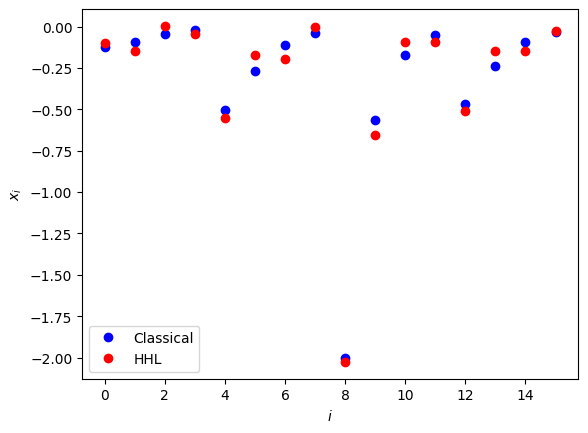

In [33]:
precision = QPE_SIZE
qsol = show_solutions(A, b, circuit_hhl_exact, res_hhl_exact, precision, check=False)

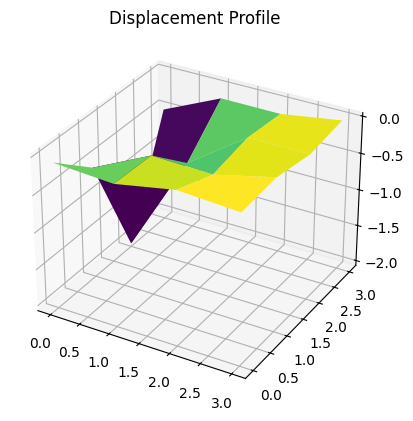

In [35]:
plot_displacement(qsol,n)